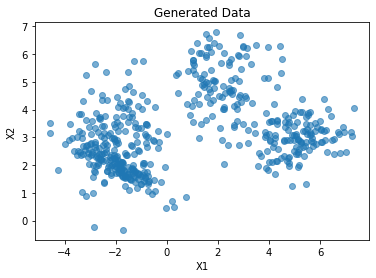

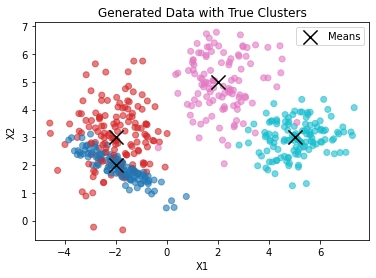

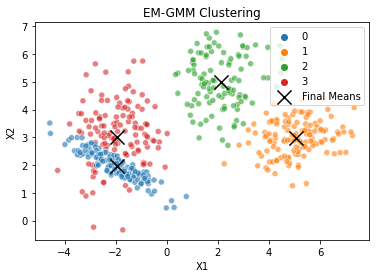

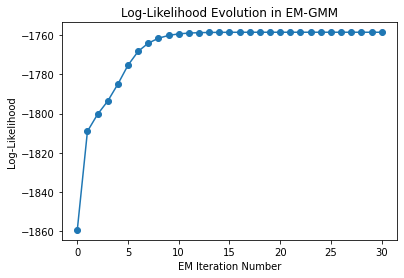

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

# Parameters
n = 500  # Number of data points
d = 2    # Data dimensionality
K = 4    # Number of Gaussian components

# Mixing proportions
Pi = np.ones(K) / K

# Mean vectors
Mu = np.array([[-2, 2], [-2, 3], [2, 5], [5, 3]])

# Covariance matrices
Sigma = np.array([np.eye(d) for _ in range(K)])
Sigma[0] = np.array([[1, -0.5], [-0.5, 0.3]])
Sigma[K-1] = np.array([[1, 0], [0, 0.3]])

# Generate data
X = np.zeros((n, d))
z = np.zeros(n, dtype=int)

for i in range(n):
    zi = np.random.choice(K, p=Pi)
    z[i] = zi
    X[i, :] = np.random.multivariate_normal(Mu[zi], Sigma[zi])

# Plot generated data
plt.figure()
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.title("Generated Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Plot means and clusters
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=z, cmap='tab10', alpha=0.6)
plt.scatter(Mu[:, 0], Mu[:, 1], c='k', marker='x', s=200, label='Means')
plt.legend()
plt.title("Generated Data with True Clusters")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Gaussian Mixture Model with EM Algorithm
def EM_GMM(X, K, tol=1e-6, max_iter=100):
    n, d = X.shape
    
    # Initialization
    Pi = np.ones(K) / K
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42).fit(X)
    Mu = kmeans.cluster_centers_
    Sigma = np.array([np.eye(d) for _ in range(K)])
    prev_loglik = -np.inf
    stored_loglik = []
    
    for t in range(max_iter):
        # E-Step
        pikFik = np.zeros((n, K))
        for k in range(K):
            pikFik[:, k] = Pi[k] * multivariate_normal.pdf(X, Mu[k], Sigma[k])
        Tau = pikFik / (pikFik.sum(axis=1, keepdims=True))
        
        # M-Step
        for k in range(K):
            nk = Tau[:, k].sum()
            Pi[k] = nk / n
            Mu[k] = (Tau[:, k][:, np.newaxis] * X).sum(axis=0) / nk
            Xc = X - Mu[k]
            Sigma[k] = (Xc.T @ (Xc * Tau[:, k][:, np.newaxis])) / nk
        
        # Compute log-likelihood
        loglik = np.sum(np.log(pikFik.sum(axis=1)))
        stored_loglik.append(loglik)
        
        # Convergence check
        if np.abs(loglik - prev_loglik) < tol:
            break
        prev_loglik = loglik
    
    # MAP classification
    z = np.argmax(Tau, axis=1)
    return Pi, Mu, Sigma, z, stored_loglik

# Run EM-GMM
K = 4  # Change K for clustering
Pi, Mu, Sigma, z, stored_loglik = EM_GMM(X, K)

# Plot clustered data
plt.figure()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=z, palette='tab10', alpha=0.6)
plt.scatter(Mu[:, 0], Mu[:, 1], c='k', marker='x', s=200, label='Final Means')
plt.legend()
plt.title("EM-GMM Clustering")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Plot log-likelihood evolution
plt.figure()
plt.plot(stored_loglik, marker='o')
plt.xlabel("EM Iteration Number")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood Evolution in EM-GMM")
plt.show()
